In [1]:
pip install openseespy opsvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 17.8 MB/s eta 0:00:00


In [2]:
import openseespy.opensees as ops
import opsvis as opsv
import os
import matplotlib.pyplot as plt

In [3]:
ops.wipe()
DataDir = r'Output'
if not os.path.exists(DataDir):
  os.makedirs(DataDir)

In [4]:

# Creating 2D Model
ops.model('Basic', '-ndm', 2, '-ndf', 3)

# Defining problem
numBay = 1
numFloor = 1

# Parameters
L = 30.0 # bay width (in ft)
H = 18.0 # storey height (in ft)
H2 = 14.0 # height to lower chord of truss
l = 5.5 # horizontal truss element length
Lc = 8 # Chord member length
h = 4.0 # vertical member height
F = 10.0 # lateral load magnitude

# Material properties (steel)
E = 29007.6 # ksi
lm = 396.78 # lumped mass (in kips)
Fy = 50.0 # ksi (assumed)

# Section properties
A_col = 86 # in^2
Ix = 14900 # in^4
Iy = 1100 # in^4
A0 = 31.495 # in^2 (Chord-2)
I2 = 132.18 # in^4
A1 = 9.58 # in^2 (Vertical-1)
Iv = 52.0 # in^4
A2 = 14.68 # in^2 (Diagonals)
Id = 117.25 # in^4
A = 17.62 # in^2 (Chord-1/SS/Vertical-SS)
I1 = 34.52 # in^4
Ivs = 206.0 # in^4

b = 0.10
R0, cR1, cR2 = 18.0, 0.925, 0.15 #Values from 3-Story building code

ops.uniaxialMaterial('Steel02', 1, Fy, E, b, R0, cR1, cR2)

# Geometric transformation for force-based elements
ops.geomTransf('PDelta', 1)

ops.beamIntegration('Lobatto', 1, 1, 5)

#For defining fiber sections:
# **Assuming all sections to be I sections**

#For column(W30X292 section): SecTag = 1
#For chord-2 (C10 X 30 x 1.5 in plate): SecTag = 2
#For vertical-1 (MC6X16.3): SecTag = 3
#For diagonals (MC10X25): SecTag = 4
#For chord-1 & chord-SS{C10 X 30}: SecTag = 5
#vertical-SS{C10 X 30}: SecTag = 6

#for defining a function: get_fiber_counts(d, bf, tf, tw)
#Storing d, bf, tf, tw values for all sections in arrays.
#double channel, a/c to standard STMF idealization:
#no need to consider 1 inch gap in any of the d, bf, tf, tw calculation.
#d, tf and bf stays the same while tw gets doubled
#For plate case: tw_eff = 2*tw + plate thickness(.673*2 + 1.5)

#depth = [32.0, 10.0, 6.0, 10.0, 10.0, 10.0] #d
#w_flange = [15.3, 3.03, 3.0, 3.41, 3.03, 3.03] #bf
#t_flange = [1.85, 0.436, .475, .575, .436, .436] #tf
#t_web = [1.02, 2.846, .75, 0.76, 1.346, 1.346] #tw

def get_fiber_counts(d, bf, tf, tw):
  n_bf = max(1, int(bf / 0.5))       # fibers along flange width
  n_tf = max(1, int(tf / 0.25))      # fibers along flange thickness
  web_height = d - 2 * tf
  n_tw = max(1, int(tw / 0.25))      # fibers along web thickness
  n_web = max(4, int(web_height / 0.5))  # vertical fibers in web
  return (d, bf, tf, tw, n_bf, n_tf, n_tw, n_web)
#no_bf=[]
#no_tf=[]
#no_tw=[]
#no_web=[]
#for i in range(len(depth)):
#  no_bf, no_tf, no_tw, no_web = get_fiber_counts(depth[i], w_flange[i], t_flange[i], t_web[i])

sections = [
    get_fiber_counts(32.0, 15.3, 1.85, 1.02),     # Main column
    get_fiber_counts(10.0, 3.03, 0.436, 2.846),# Chord-2
    get_fiber_counts(6.0, 3.0, 0.475, 0.75),# Vertical-1
    get_fiber_counts(10.0, 3.41, 0.575, 0.76),# Diagonal
    get_fiber_counts(10.0, 3.03, 0.436, 1.346),# Chord-SS
    get_fiber_counts(10.0, 3.03, 0.436, 1.346) # Vertical-SS
]

#Loop to define all 6 fibersections(assuming I sections)
def define_fiber_sections():
    for i, (d, bf, tf, tw, n_bf, n_tf, n_tw, n_web) in enumerate(sections):
        secTag = i + 1

        ops.section('Fiber', secTag, '-GJ', 1e6)

        # Top flange
        ops.patch('rect', 1, n_bf, n_tf,
                  -bf/2, d/2 - tf,
                   bf/2, d/2)

        # Web
        ops.patch('rect', 1, n_tw, n_web,
                  -tw/2, -d/2 + tf,
                   tw/2,  d/2 - tf)

        # Bottom flange
        ops.patch('rect', 1, n_bf, n_tf,
                  -bf/2, -d/2,
                   bf/2, -d/2 + tf)


define_fiber_sections()

# Node coordinates
coords = [
    (10,0,0), (20,L,0), (11,0,H), (21,L,H),
    (110,0,H2), (210,L,H2),
    (111,l,H2), (112,2*l,H2), (113,2*l + Lc,H2), (114,L - l,H2),
    (115,l,H), (116,2*l,H), (117,2*l + Lc,H), (118,L - l,H),
    (30,2*L,0), (31,2*L,H)
]
for tag, x, y in coords:
    ops.node(tag, x, y)

# Boundary conditions
for i in [10,20,30]:
    ops.fix(i,1,1,0)

# Main columns
ops.element('forceBeamColumn', 1, 10, 110, 1, 1, '1')
ops.element('forceBeamColumn', 2, 20, 210, 1, 1, '1')
ops.element('forceBeamColumn', 21, 110, 11, 1, 1, '1')
ops.element('forceBeamColumn', 22, 210, 21, 1, 1, '1')

# Chord-2
ops.element('forceBeamColumn', 3, 110, 111, 1, 1, '2')
ops.element('forceBeamColumn', 4, 114, 210, 1, 1, '2')
ops.element('forceBeamColumn', 5, 11, 115, 1, 1, '2')
ops.element('forceBeamColumn', 6, 118, 21, 1, 1, '2')

# Chord-1
ops.element('forceBeamColumn', 7, 111, 112, 1, 1, '5')
ops.element('forceBeamColumn', 8, 113, 114, 1, 1, '5')
ops.element('forceBeamColumn', 9, 115, 116, 1, 1, '5')
ops.element('forceBeamColumn', 10, 117, 118, 1, 1, '5')

# Vertical-1
ops.element('forceBeamColumn', 11, 111, 115, 1, 1, '3')
ops.element('forceBeamColumn', 12, 114, 118, 1, 1, '3')

# Vertical-SS
ops.element('forceBeamColumn', 13, 112, 116, 1, 1, '6')
ops.element('forceBeamColumn', 14, 113, 117, 1, 1, '6')

# Diagonals
ops.element('forceBeamColumn', 15, 11, 111, 1, 1, '4')
ops.element('forceBeamColumn', 16, 111, 116, 1, 1, '4')
ops.element('forceBeamColumn', 17, 117, 114, 1, 1, '4')
ops.element('forceBeamColumn', 18, 114, 21, 1, 1, '4')

# Chord-SS
ops.element('forceBeamColumn', 19, 112, 113, 1, 1, '5')
ops.element('forceBeamColumn', 20, 116, 117, 1, 1, '5')

# Lean-on column and support
ops.section('Elastic', 7, E, 10*A1, 10*I1)
ops.element('forceBeamColumn', 23, 21, 31, 1, 1, '7')
ops.element('forceBeamColumn', 24, 31, 30, 1, 1, '1')
ops.mass(31, lm, 0.0)
ops.equalDOF(21, 31, 1, 2)

# Loading
ops.timeSeries("Linear", 1)
ops.pattern("Plain", 1, 1)
ops.load(11, 0.0, -F*100, 0.0)


In [5]:
ops.recorder('Node', '-file', 'disp.out', '-time', '-node', 11, 21, 116, 117, '-dof', 1,2, 3, 'disp')
ops.recorder('Element', '-file', 'forces.out', '-time', '-ele', 1, 2, 3, 4, 19, 20, 'force')


1

In [6]:
# Analysis
ops.constraints("Plain")
ops.numberer("RCM")
ops.system("BandGeneral")
ops.test('NormDispIncr', 1.0e-6, 10)
ops.algorithm("Newton") #Linear -> Newton (for non-linear)
ops.integrator("LoadControl", 1)
ops.analysis("Static")



# Perform static analysis:
ops.analyze(1)

0

In [7]:
# Get displacement at node 11
ux, uy, rz = ops.nodeDisp(11)
print(f'Displacement at Node 11: ux = {ux:.5f}, uy = {uy:.5f}, rz = {rz:.5f}')

# Example for element tag 1
print('Element forces (global):', ops.eleForce(1))


Displacement at Node 11: ux = -0.00229, uy = -0.00634, rz = 0.00026
Element forces (global): [-14.844727363791044, 965.3315367966718, 6.208243364874827e-14, 14.844727363791044, -965.3315367966718, 206.37681727390205]


<Axes: >

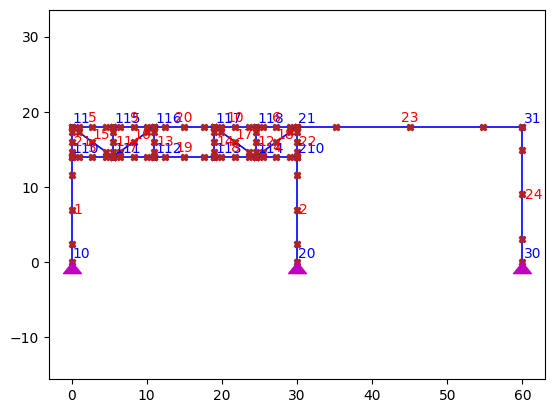

In [8]:
opsv.plot_model()

<Axes: >

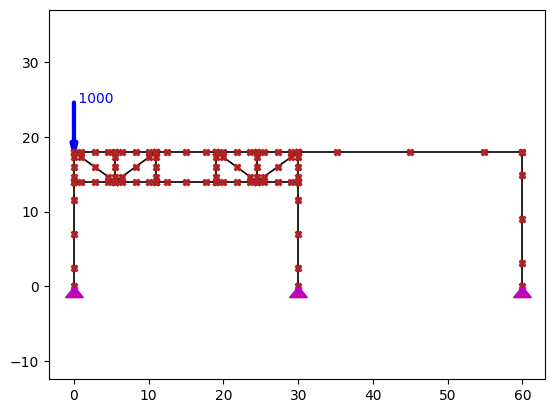

In [9]:
opsv.plot_load()

np.float64(926.2977664206585)

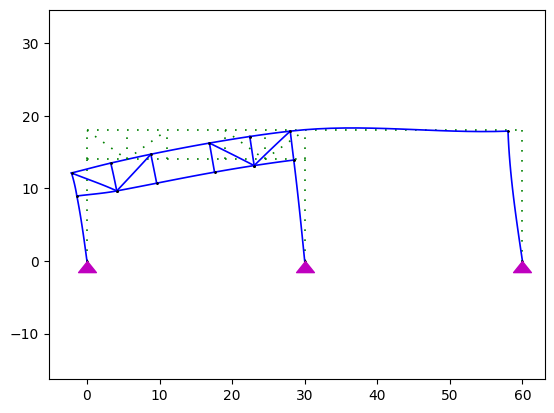

In [11]:
opsv.plot_defo()